# 프로젝트3 : 카메라 스티커앱 만들기 첫걸음

(1) 얼굴인식 카메라의 흐름

  얼굴이 포함된 사진 준비 -> 얼굴의 bounding box 찾기 -> 눈, 코, 입, 귀 등의 landmark 찾기 -> 찾아진 영역으로 부터 원하는 스티커 부착
  

(2) dlib 라이브러리란?

 사이킷런은 2가지 데이터셋을 제공한다고 위에서 말했는데 그 중에서도 Toy Dataset을 활용하여 프로젝트를 진행하고자 한다.
 
- Optical recognition of handwritten digits dataset : 손글씨 이미지 데이터
- Wine recognition dataset: 와인 데이터
- Breast cancer wisconsin (diagnostic) dataset : 유방암 데이터


## 목차

1. 사진 준비
2. 얼굴 검출 face detection


4. 회고

###**1. 사진 준비**

디렉토리 생성

In [ ]:
! mkdir project3
! mkdir project3/model
! ls

mkdir: cannot create directory ‘project3’: File exists
aiffel	 project3     selfie.jpg
cat.png  sample_data  shape_predictor_68_face_landmarks.dat.bz2


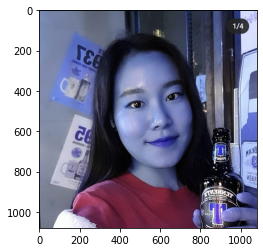

In [ ]:
#찾은 이미지 출력

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import dlib

my_image_path = '/content/sample_data/selfie.jpg'
img_bgr = cv2.imread(my_image_path)    # OpenCV로 이미지를 불러옵니다
img_show = img_bgr.copy()      # 출력용 이미지를 따로 보관합니다
plt.imshow(img_bgr)
plt.show()

❗ pencv는 BGR(파랑, 녹색, 빨강)을 사용하기 때문에 원본의 빨간색이 파란색으로, 원본의 파란색이 빨간색으로 반전되어 나온다.

따라서 다른 이미지 라이브러리에서 사용하기 위해서는 색 보정처리가 필요하다.

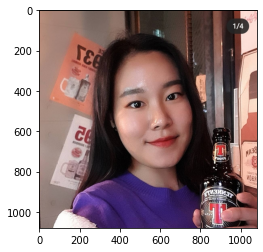

In [ ]:
#이미지 색상 복구
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

❗ detector_hog의 두 번째 파라미터는 이미지 피라미드의 수입니다. 이미지를 upsampling 방법을 통해 크기를 키우는 것을 이미지 피라미드라고 합니다. 이미지 피라미드에서 얼굴을 다시 검출하면 작게 촬영된 얼굴을 크게 볼 수 있기 때문에 더 정확한 검출이 가능합니다. 

### **2. 얼굴 검출 face detection**

dlib의 face detector는 HOG(Histogram of Oriented Gradients)와 SVM(Support Vector Machine)을 사용해서 얼굴 찾기

이때 HOG는 이미지에서 색상의 변화량을 나타낸 것

In [ ]:
# detector를 선언
detector_hog = dlib.get_frontal_face_detector()
print("🌫🛸")

# detector_hog를 이용해서 얼굴의 bounding box를 추출
# dlib은 rgb 이미지를 입력으로 받기 때문에 cvtColor() 를 이용해 bgr을 rgb로 변환
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
dlib_rects = detector_hog(img_rgb, 1)   # (image, num of image pyramid)
print("🌫🛸")

🌫🛸
🌫🛸


detector_hog의 두 번째 파라미터는 이미지 피라미드의 수입니다. 

이미지를 upsampling 방법을 통해 크기를 키우는 것을 이미지 피라미드라고 합니다.

이미지 피라미드에서 얼굴을 다시 검출하면 작게 촬영된 얼굴을 크게 볼 수 있기 때문에 더 정확한 검출이 가능


rectangles[[(348, 297) (810, 759)]]


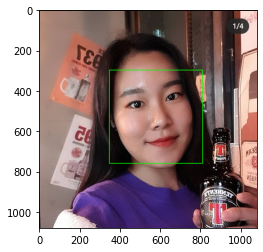

In [ ]:
# 찾은 얼굴 영역 박스 리스트
# 여러 얼굴이 있을 수 있습니다
print(dlib_rects)   

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()


dlib.rectangle객체는 left(), top(), right(), bottom(), height(), width() 등의 멤버 함수를 포함

### **3. 얼굴 랜드마크 face landmark**

 weight file 다운받기

In [ ]:
! wget http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
! ls
! cp ./shape_predictor_68_face_landmarks.dat.bz2 ./project3/model/
! bzip2 -d /content/project3/model/shape_predictor_68_face_landmarks.dat.bz2

--2022-01-11 08:03:41--  http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
Resolving dlib.net (dlib.net)... 107.180.26.78
Connecting to dlib.net (dlib.net)|107.180.26.78|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 64040097 (61M)
Saving to: ‘shape_predictor_68_face_landmarks.dat.bz2.1’

     shape_predicto  24%[===>                ]  14.81M  5.89MB/s               ^C
aiffel	     shape_predictor_68_face_landmarks.dat.bz2
project3     shape_predictor_68_face_landmarks.dat.bz2.1
sample_data
bzip2: Output file /content/project3/model/shape_predictor_68_face_landmarks.dat already exists.


In [ ]:
# 저장한 landmark 모델을 불러오기

model_path = '/content/project3/model/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)
print("🌫🛸")

🌫🛸


❗ landmark_predictor 는 RGB 이미지와 dlib.rectangle을 입력 받아 dlib.full_object_detection 를 반환

In [ ]:
list_landmarks = []

# 얼굴 영역 박스 마다 face landmark를 찾아냅니다
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    # face landmark 좌표를 저장해둡니다
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

print(len(list_landmarks[0]))

68


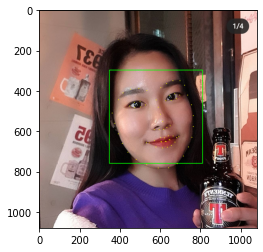

In [ ]:
for landmark in list_landmarks:
    for point in landmark:
        cv2.circle(img_show, point, 2, (0, 255, 255), -1)

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

In [ ]:
#코 좌표 확인
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print (landmark[30]) # 코의 index는 30 입니다
    x = landmark[30][0]
    y = landmark[30][1] - dlib_rect.height()//2
    w = h = dlib_rect.width()
    print ('(x,y) : (%d,%d)'%(x,y))
    print ('(w,h) : (%d,%d)'%(w,h))

(612, 552)
(x,y) : (612,321)
(w,h) : (463,463)


(463, 463, 3)


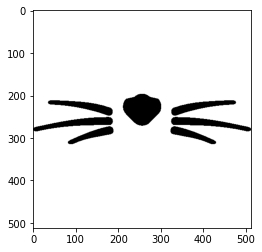

In [ ]:
sticker_path = '/content/sample_data/cat.png'
img_sticker = cv2.imread(sticker_path) # 스티커 이미지를 불러옵니다
plt.imshow(img_sticker)
img_sticker = cv2.resize(img_sticker, (w,h))
print (img_sticker.shape)

In [ ]:
#x, y 좌표 조절
refined_x = x - w // 2
refined_y = y    #위 아래 위치를 조절해줌
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (381,321)


In [ ]:
#-크롭
if refined_x < 0: 
    img_sticker = img_sticker[:, -refined_x:]
    refined_x = 0
if refined_y < 0:
    img_sticker = img_sticker[-refined_y:, :]
    refined_y = 0

print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (381,321)


슝~


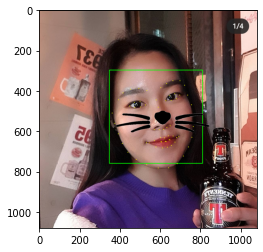

In [ ]:
#스티커 적용 후 출력
# 길어서 복잡해 보이지만 img_show[from:to] 형식입니다
sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)    # 이 조건을 바꿔줌 , 어려운 부분이군.. 동섭님은 img_sticker!=0 이렇게 하셨다고 함
print("슝~")

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

5. 여러 종류의 이미지 테스트

###**4. 회고**

(1) Open CV

컴퓨터 비전 관련 프로그래밍을 쉽게 할 수 있도록 도와주는 라이브러리

이미지 딥러닝(알파고 기술)에도 많이 활용

이미지채널로  BGR(파랑, 녹색, 빨강)을 사용하기 때문에 opencv에서 다룬 이미지를 다른 이미지 라이브러리를 활용하여 출력하려면 색 보정처리가 필요함

(2) 컴퓨터 비전(Computer Vision)이란?

카메라, 에지 기반 또는 클라우드 기반 컴퓨팅, 소프트웨어 및 인공 지능(AI)을 결합하여 시스템이 사물을 "확인"하고 식별할 수 있게 함

(3)  np.where
 np.where(배열에 대한 조건문, 참일때 값, 거짓일때 값)의 형태로 사용
 https://yganalyst.github.io/data_handling/memo_3/